In [12]:
# !git clone https://github.com/time-series-foundation-models/lag-llama/
# !pip3 install -r requirements.txt --quiet
# !huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir lag-llama

In [1]:
cd lag-llama

/Users/alvarocorralescano/Documents/GitHub/wave-height-prediction/lag-llama


In [3]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from tqdm.autonotebook import tqdm

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator

We create a function for Lag-Llama inference that we can reuse. This function returns the predictions for the given prediction horizon. The forecast will be of shape (num_samples, prediction_length), where `num_samples` is the number of samples sampled from the predicted probability distribution for each timestep.

In [4]:
    def get_lag_llama_predictions(dataset, prediction_length, context_length=32, num_samples=20, device="cpu", batch_size=64, nonnegative_pred_samples=True):
        ckpt = torch.load("lag-llama/lag-llama.ckpt", map_location=torch.device(device))
        estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

        estimator = LagLlamaEstimator(
            # ckpt_path="lag-llama.ckpt",
            ckpt_path = 'lag-llama/lag-llama.ckpt',
            prediction_length=prediction_length,
            context_length=context_length,
            device = device

            # estimator args
            input_size=estimator_args["input_size"],
            n_layer=estimator_args["n_layer"],
            n_embd_per_head=estimator_args["n_embd_per_head"],
            n_head=estimator_args["n_head"],
            scaling=estimator_args["scaling"],
            time_feat=estimator_args["time_feat"],

            nonnegative_pred_samples=nonnegative_pred_samples,

            # linear positional encoding scaling
            rope_scaling={
                "type": "linear",
                "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
            },

            batch_size=batch_size,
            num_parallel_samples=num_samples,
        )

        lightning_module = estimator.create_lightning_module().to(device)
        transformation = estimator.create_transformation()
        predictor = estimator.create_predictor(transformation, lightning_module)

        forecast_it, ts_it = make_evaluation_predictions(
            dataset=dataset,
            predictor=predictor,
            num_samples=num_samples
        )
        forecasts = list(tqdm(forecast_it, total=len(dataset), desc="Forecasting batches"))
        tss = list(tqdm(ts_it, total=len(dataset), desc="Ground truth"))

        return forecasts, tss

In [5]:
dataset = get_dataset("m4_weekly")

In [6]:
prediction_length = dataset.metadata.prediction_length
context_length = prediction_length*3
num_samples = 20
device = torch.device('cpu')

In [7]:
forecasts, tss = get_lag_llama_predictions(
    dataset.test,
    prediction_length=prediction_length,
    num_samples=num_samples,
    context_length=context_length,
    device=device
)

Forecasting batches:   0%|          | 0/359 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/359 [00:00<?, ?it/s]

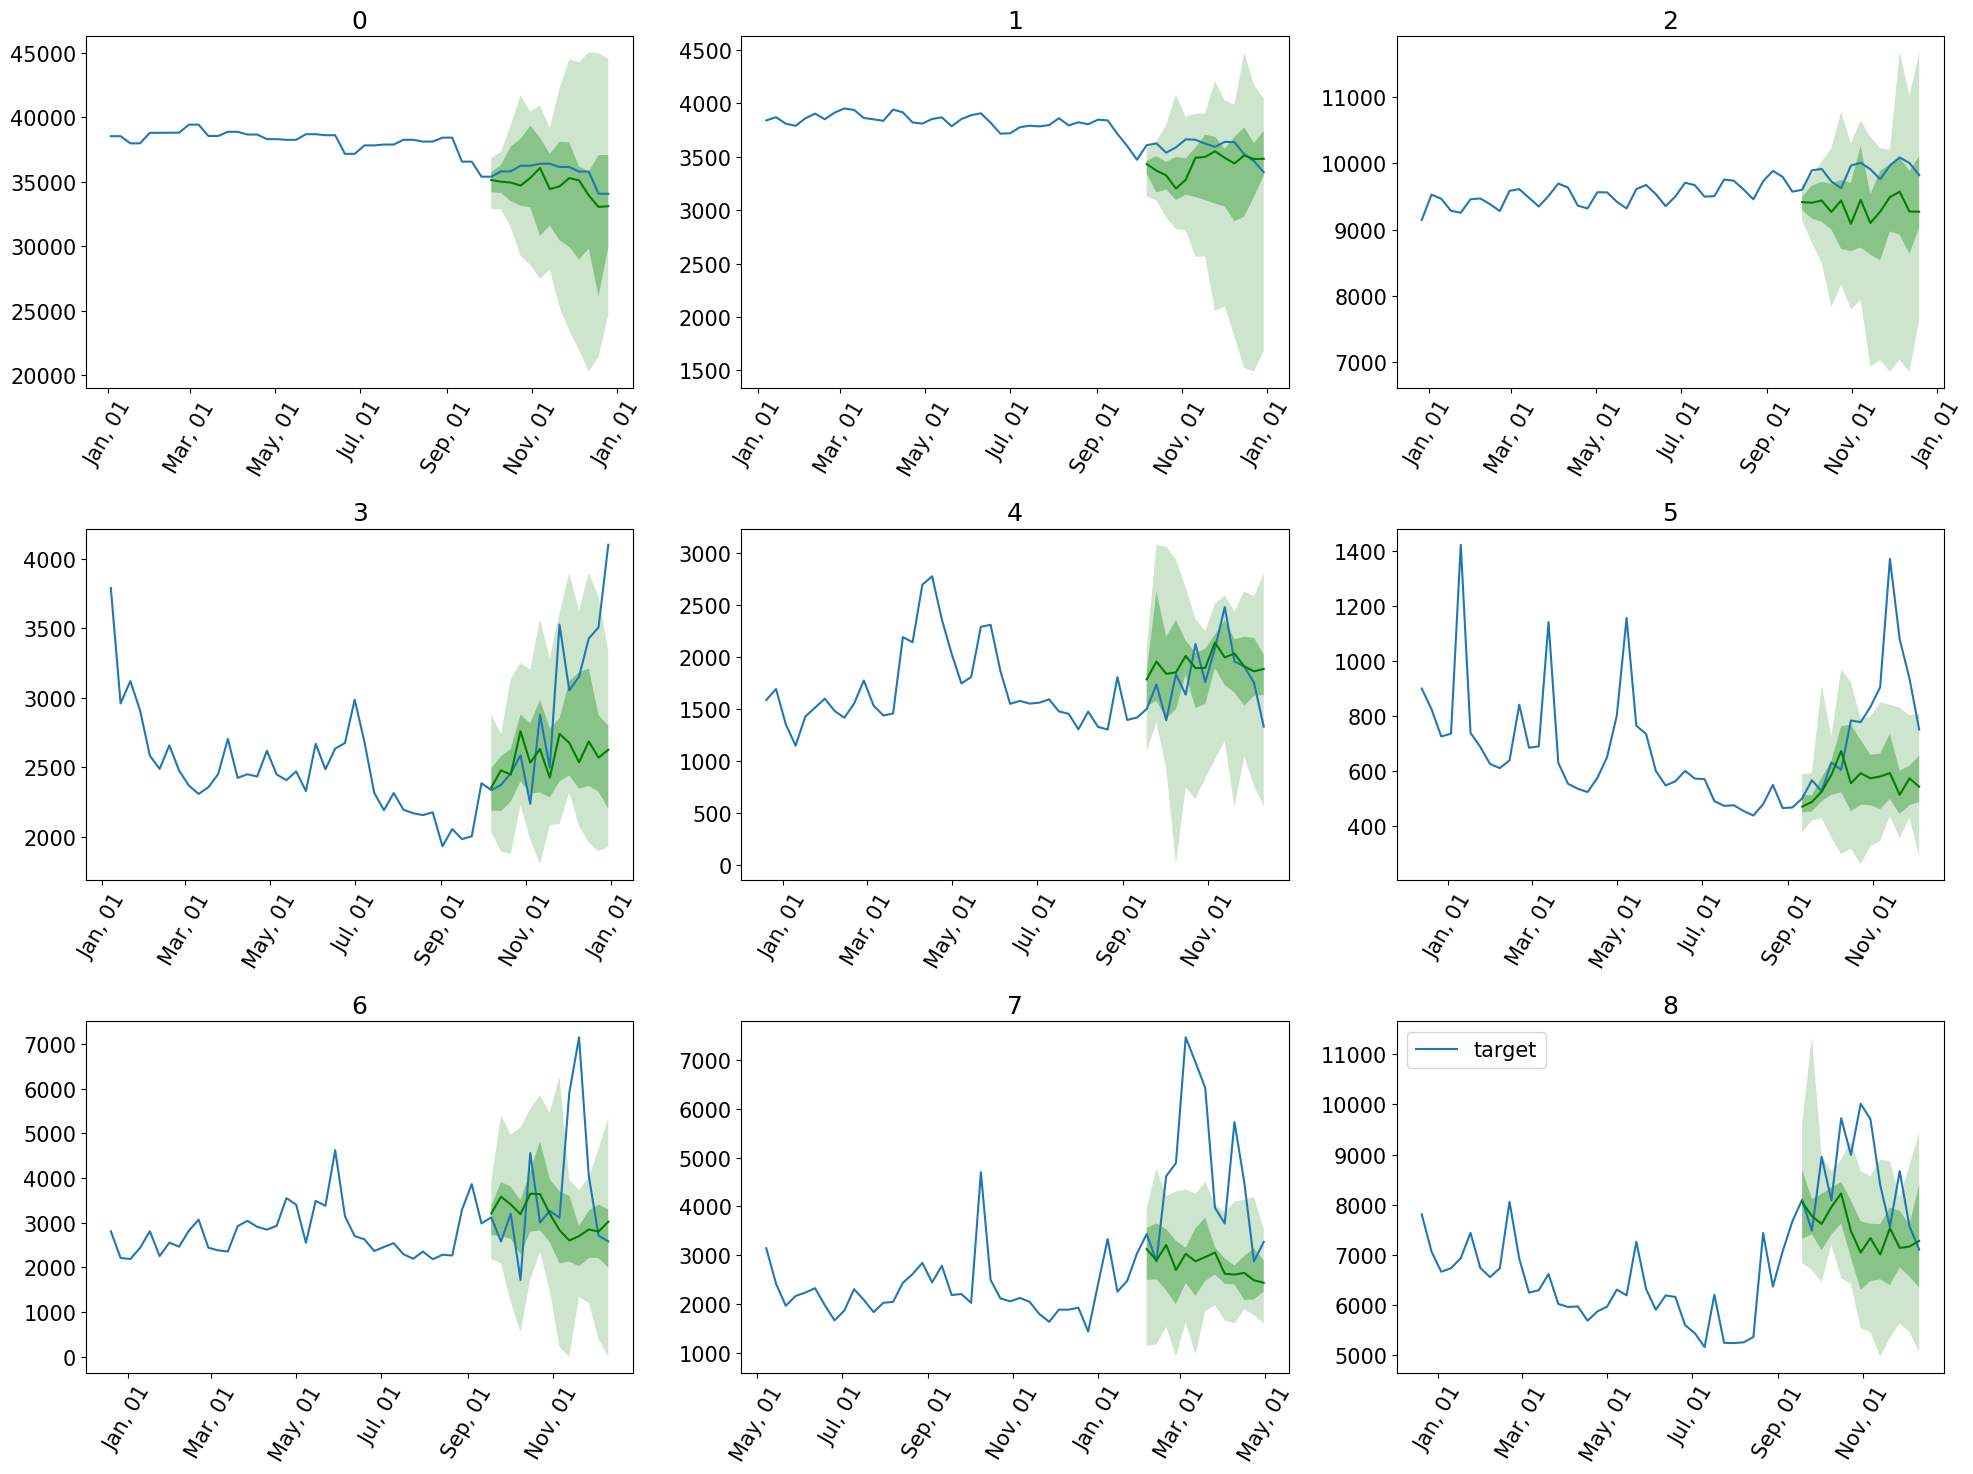

In [8]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [7]:
!pwd

/Users/alvarocorralescano/Documents/GitHub/wave-height-prediction/lag-llama


In [25]:
import torch
from tqdm import tqdm

def get_lag_llama_predictions(dataset, prediction_length, context_length=32, num_samples=20, device="cpu", batch_size=64, nonnegative_pred_samples=True):
    # Ensure device is set to CPU
    device = torch.device(device)
    
    # Load the checkpoint with map_location set to the specified device
    print("Loading checkpoint...")
    ckpt = torch.load("lag-llama/lag-llama.ckpt", map_location=device)
    print("Checkpoint loaded successfully.")

    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    estimator = LagLlamaEstimator(
        ckpt_path='lag-llama/lag-llama.ckpt',
        prediction_length=prediction_length,
        context_length=context_length,

        # Estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],

        nonnegative_pred_samples=nonnegative_pred_samples,

        # Linear positional encoding scaling
        rope_scaling={
            "type": "linear",
            "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        },

        batch_size=batch_size,
        num_parallel_samples=num_samples,
    )

    # Ensure the model is on the specified device
    print("Creating lightning module...")
    lightning_module = estimator.create_lightning_module()
    lightning_module.to(device)  # Move the module to the specified device
    print("Lightning module created and moved to device.")

    print("Creating transformation...")
    transformation = estimator.create_transformation()
    print("Transformation created.")

    print("Creating predictor...")
    predictor = estimator.create_predictor(transformation, lightning_module)
    print("Predictor created.")

    # Make evaluation predictions
    print("Making evaluation predictions...")
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(tqdm(forecast_it, total=len(dataset), desc="Forecasting batches"))
    tss = list(tqdm(ts_it, total=len(dataset), desc="Ground truth"))

    print("Predictions complete.")
    return forecasts, tss

# Assuming dataset is already loaded and available
prediction_length = dataset.metadata.prediction_length
context_length = prediction_length * 3
num_samples = 20
device = 'cpu'

forecasts, tss = get_lag_llama_predictions(
    dataset.test,
    prediction_length=prediction_length,
    num_samples=num_samples,
    context_length=context_length,
    device=device
)


Loading checkpoint...
Checkpoint loaded successfully.
Creating lightning module...


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.